In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pyautogui
import re
from bs4 import BeautifulSoup
import sys
sys.path.append('..')
import constants.constants as const
import constants.file_handler_constants as fh
from constants.restaurant_constants import *

from packages.restaurant.Restaurant import *
from packages.file_handler_package.file_handler import *

import os
import glob
import time
import pandas as pd
import numpy as np
from dotenv import load_dotenv, dotenv_values 

from selenium.webdriver import Remote, ChromeOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.actions.wheel_input import ScrollOrigin
from selenium.webdriver import ActionChains

from seleniumwire import webdriver
from selenium.webdriver.edge.service import Service
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.webdriver.edge.options import Options


from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
def create_restaurant_df(restaurant: Restaurant) -> pd.DataFrame:
    restaurant_dict = {
        'name': [restaurant.get_name()],
        'sub_name': [restaurant.get_sub_name()],
        'wongnai_url' : [restaurant.get_wongnai_url()],
        'restaurantType' : [restaurant.get_restaurantType()],
        'facility' : [restaurant.get_facility()],
        'description' : [restaurant.get_description()],
        'imgPath': [restaurant.get_imgPath()],
        'phone' : [restaurant.get_phone()],
        'website' : [restaurant.get_website()],
        'openingHour' : [restaurant.get_openingHour()],
        'priceRange' : [restaurant.get_priceRange()],
        'latitude' : [restaurant.get_latitude()],
        'longitude' : [restaurant.get_longitude()],
        # location
        'address' : [restaurant.get_location().get_address()],
        'province' : [restaurant.get_location().get_province()],
        'district' : [restaurant.get_location().get_district()],
        'subDistrict' : [restaurant.get_location().get_subDistrict()],
        'province_code' : [restaurant.get_location().get_province_code()],
        'district_code' : [restaurant.get_location().get_district_code()],
        'sub_district_code' : [restaurant.get_location().get_sub_district_code()],

        # rating
        'score' : [restaurant.get_rating().get_score()],
        'ratingCount' : [restaurant.get_rating().get_ratingCount()],
    }
    
    restaurant_df = pd.DataFrame(restaurant_dict)
    
    return restaurant_df.copy()

In [3]:
def convert_openinghours(openingHours: dict) -> dict:
    temp_openingHours = openingHours.copy()

    if(len(temp_openingHours) == 0):
        return temp_openingHours.copy()
    
    # cut substring represent special holiday
    # for example:
    # {'วันจันทร์(วันเฉลิมพระชนมพรรษา พระบาทสมเด็จพระปรเมนทรรามาธิบดีศรีสินทรมหาวชิราลงกรณ พระวชิรเกล้าเจ้าอยู่หัว (วันหยุดชดเชย))': '9:00–17:00'}
    # change its key to -> {'วันจันทร์': '9:00–17:00'}
    for key, val in temp_openingHours.copy().items():
        start_Idx_special_holiday = key.find('(')
        if(start_Idx_special_holiday != -1):
            # changing keys of dictionary
            new_key = key[:start_Idx_special_holiday]
            temp_openingHours[new_key] = temp_openingHours.pop(key)

    days_of_week = ['อาทิตย์', 'จันทร์', 'อังคาร', 'พุธ', 'พฤหัสบดี', 'ศุกร์', 'เสาร์']
    # in case of temp_openingHours = {"ทุกวัน": '10:30 - 21:00'}
    # convert it to dictionary with all days of week as a keys(same value)
    if(len(temp_openingHours) == 1 and list(temp_openingHours.keys())[0] == 'ทุกวัน'):
        temp_time = list(temp_openingHours.values())[0]
        del temp_openingHours['ทุกวัน']
        for cur_day_of_week in days_of_week:
            temp_openingHours[cur_day_of_week] = temp_time

    else:
        # if there is range between day of week --> convert it to two individual key with same value
        # for example: {'จันทร์ - พุธ': '10:00 - 20:30', 'อาทิตย์': '11:00 - 22:30'}
        # convert to -> {'จันทร์': '10:00 - 20:30', 'อังคาร': '10:00 - 20:30', 'พุธ': '10:00 - 20:30', 'อาทิตย์': '11:00 - 22:30'}
        for key, val in temp_openingHours.copy().items():
            cur_split_day_range = key.split(' - ')
            if(len(cur_split_day_range) == 1):
                continue
            # remove current key
            del temp_openingHours[key]
            # convert to two individual key with same value
            is_pass_endDay = False
            cur_start_day = cur_split_day_range[0]
            cur_end_day = cur_split_day_range[1]
            cur_Idx = days_of_week.index(cur_start_day)
            while(not is_pass_endDay):
                if(days_of_week[cur_Idx] == cur_end_day):
                    is_pass_endDay = True
                temp_openingHours[days_of_week[cur_Idx]] = val
                cur_Idx = (cur_Idx + 1) % len(days_of_week)

    # change openingHours to temp_openingHours
    return temp_openingHours.copy()

In [4]:
def scrape_img(restaurant_page_driver: webdriver) -> list[str]:
    img_address = []
    
    options = webdriver.ChromeOptions()
    options.add_argument("start-maximized")
    
    try:
        find_mark_Idx = restaurant_page_driver.current_url.find('?')
        res_mark_Idx = find_mark_Idx if find_mark_Idx != -1 else len(restaurant_page_driver.current_url)
        # example of restaurant without photos: https://www.wongnai.com/restaurants/95958BB-%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%99%E0%B8%95%E0%B8%AD%E0%B8%87%E0%B8%AB%E0%B8%99%E0%B8%B6%E0%B9%88%E0%B8%87%E0%B8%AA%E0%B9%80%E0%B8%95%E0%B9%8A%E0%B8%81/photos
        
        cnt_retry = 0

        cnt_proxy_port = 10000
        max_proxy_port = 20000

        while(True):
            if(cnt_retry == 5):
                print("max retry for scrape_img ...")
                break
            # seach image section of current restaurant by this query
            all_img_query = '%s/photos' % (restaurant_page_driver.current_url[:res_mark_Idx])

            print("scrape img...")
            print("for: ", all_img_query)

            # formulate the proxy url with authentication
            proxy_url = f"http://{os.environ['proxy_username']}:{os.environ['proxy_password']}@{os.environ['proxy_address']}:{cnt_proxy_port}"
            
            # change the port with each new request (can use any port from 10000 to 20000). 
            # for example: in the first request 10000 port in the next request 10001 and so on.
            cnt_proxy_port += 1
            if(cnt_proxy_port > max_proxy_port):
                cnt_proxy_port = 10000

            # set selenium-wire options to use the proxy
            seleniumwire_options = {
                "proxy": {
                    "http": proxy_url,
                    "https": proxy_url
                },
            }

            # set Chrome options to run in headless mode
            options = Options()
            options.add_argument("start-maximized")
            # options.add_argument("--headless=new")
            options.add_experimental_option(
                "prefs", {"profile.managed_default_content_settings.images": 2}
            )

            # initialize the Chrome driver with service, selenium-wire options, and chrome options
            all_img_driver = webdriver.Edge(
                service=Service(EdgeChromiumDriverManager().install()),
                seleniumwire_options=seleniumwire_options,
                options=options
            )
            all_img_driver.get(all_img_query)
            print("after get to img url --> enter scrape img flow ...")
            
            try:
                WebDriverWait(all_img_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'brqSoI')))
                all_img_elements = all_img_driver.find_elements(By.CLASS_NAME, 'brqSoI')

            except Exception as e:
                print("retry find img...")
                all_img_driver.quit()
                cnt_retry += 1
                continue

            prev_len = len(all_img_elements)
            cnt_scroll_end = 0
            max_img_cnt = 250
            try:
                while(True):
                    # check if it scroll and retrive the same amount of image for 3 time
                    # or amount of retrived images exceed "max_img_cnt" (may remove this condition later if you want all images)
                    if(cnt_scroll_end == 3 or prev_len > max_img_cnt):
                        break
                    # scroll and wait for 2 msec
                    all_img_driver.execute_script('window.scrollBy(0, document.body.scrollHeight)')
                    time.sleep(2)
                    # update value for next iteration
                    all_img_elements = all_img_driver.find_elements(By.CLASS_NAME, 'brqSoI')
                    cur_len = len(all_img_elements)
                    if(prev_len == cur_len): 
                        cnt_scroll_end += 1
                    else:
                        cnt_scroll_end = 0
                        prev_len = cur_len

            except Exception as e:
                print("prn err img 1")
                # pass
        
            # find image address and save in "img_address"
            for cur_img_element in all_img_elements:
                cur_img_address = cur_img_element.get_attribute('src')
                cur_img_address = re.sub(r"\d+x\d+", "400x0", cur_img_address)
                if(cur_img_address in img_address):
                    break
                img_address.append(cur_img_address)

            
            all_img_driver.quit()
            break

    except Exception as e:
        print("cant find image")

    return img_address.copy()

In [5]:
def scrape_location(restaurant_page_driver: webdriver, restaurant: Restaurant, province_th: str):

    # find better address description on wongnai
    # for example: "8/88 อาคารเรียน ชั้น 2F, หมู่ที่5 ศรีสุนทร ถลาง ภูเก็ต ภูเก็ต (ชาบูชิโรบินสันถลาง) อ่านต่อได้ที่"
    address_wongnai = ""
    try:
        # WebDriverWait(restaurant_page_driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jEIapA'))) 
        possible_addressWongnai_elements = restaurant_page_driver.find_elements(By.CLASS_NAME, 'jEIapA')
        for cur_element in possible_addressWongnai_elements:
            cur_text = cur_element.text
            if(province_th in cur_text):
                address_wongnai = cur_text
                break
    except Exception as e:
        pass

    print("address_wongnai --> ", address_wongnai)
    
    # find lat, long
    lat = 0
    long = 0
    try:
        # WebDriverWait(restaurant_page_driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'meta'))) 
        all_meta_data = restaurant_page_driver.find_elements(By.TAG_NAME, 'meta')
        cnt_lat_long = 0
        lat_property = "place:location:latitude"
        long_property = "place:location:longitude"
        for cur_meta_data in all_meta_data:
            if(cnt_lat_long == 2):
                break
            cur_property = cur_meta_data.get_attribute('property')
            if(cur_property):
                if(cur_property == lat_property):
                    print(cur_meta_data.get_attribute('content'))
                    lat = float(cur_meta_data.get_attribute('content'))
                    cnt_lat_long += 1
                    continue
                elif(cur_property == long_property):
                    print(cur_meta_data.get_attribute('content'))
                    long = float(cur_meta_data.get_attribute('content'))
                    cnt_lat_long += 1
                    continue

    except Exception as e:
        print("can't find lat, long")

    print("lat : ", lat)
    print("long : ", long)
    
    restaurant.set_latitude(lat)
    restaurant.set_longitude(long)

    ######

    # find location data 
    cnt_retry = 0
    
    cnt_proxy_port = 10000
    max_proxy_port = 20000

    # use 'lat', 'long' to find location data 
    try:
        while(True):
            if(cnt_retry == 10):
                print("max retry for scrape Google Map ...")
                break

            print("scrape Google Map...")

            possible_addressGoogleMap_elements = []        
            try:
                # formulate the proxy url with authentication
                proxy_url = f"http://{os.environ['proxy_username']}:{os.environ['proxy_password']}@{os.environ['proxy_address']}:{cnt_proxy_port}"
                
                # change the port with each new request (can use any port from 10000 to 20000). 
                # for example: in the first request 10000 port in the next request 10001 and so on.
                cnt_proxy_port += 1
                if(cnt_proxy_port > max_proxy_port):
                    cnt_proxy_port = 10000

                # set selenium-wire options to use the proxy
                seleniumwire_options = {
                    "proxy": {
                        "http": proxy_url,
                        "https": proxy_url
                    },
                }

                # set Chrome options to run in headless mode
                # options = Options()
                options = webdriver.ChromeOptions()
                options.add_argument("start-maximized")
                # options.add_argument("--headless=new")
                options.add_experimental_option(
                    "prefs", {"profile.managed_default_content_settings.images": 2}
                )

                # initialize the Chrome driver with service, selenium-wire options, and chrome options
                # google_map_driver = webdriver.Edge(
                #     service=Service(EdgeChromiumDriverManager().install()),
                #     seleniumwire_options=seleniumwire_options,
                #     options=options
                # )
                google_map_driver = webdriver.Chrome(options=options)
                
                google_map_query = "https://www.google.com/maps/search/?api=1&query=%s,%s" % (lat, long)
                google_map_driver.get(google_map_query)
                
                WebDriverWait(google_map_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'DkEaL')))
                possible_addressGoogleMap_elements = google_map_driver.find_elements(By.CLASS_NAME, 'DkEaL')

            except Exception as e:
                print("retry  scrape Google Map..")
                cnt_retry += 1
                google_map_driver.close()
                continue

            # if found some wiered place that doesn't even have its address
            # skip this case for now...
            if(not len(possible_addressGoogleMap_elements)):
                return

            subStrDistrict = "อำเภอ"
            subStrSubDistrict = "ตำบล"

            if province_th == "กรุงเทพมหานคร":
                subStrDistrict = "เขต"
                subStrSubDistrict = "แขวง"

            district = 0
            subDirstrict = 0

            # find location
            useData = None
            for cur_element in possible_addressGoogleMap_elements:
                if province_th in cur_element.text and cur_element.text.find(subStrDistrict) != -1:
                    useData = cur_element.text.replace(",","").replace("เเ","แ")
                    break
            
            if(useData != None):
                # print("Full Address :",useData)
                # another brute force way in case of province 'กรุงเทพหมานคร' not have word 'แขวง' in address
                if(province_th == 'กรุงเทพมหานคร' and useData.find(subStrSubDistrict) == -1):
                    subAddress_split = useData.split(' ')
                    cur_province_Idx = subAddress_split.index(province_th)
                    district = subAddress_split[cur_province_Idx - 1].replace("เขต","")
                    subDistrict = subAddress_split[cur_province_Idx - 2].replace("แขวง","")

                else:
                    start_address_index = useData.find(subStrSubDistrict)
                    subAddress = useData[start_address_index:]
                    district = subAddress[subAddress.find(subStrDistrict)+len(subStrDistrict):subAddress.find(province_th)].replace(" ","")               
                    subDistrict = subAddress[subAddress.find(subStrSubDistrict)+len(subStrSubDistrict):subAddress.find(subStrDistrict)].replace(" ","")

                if district == "เมือง":
                    district = district+province_th

                # filter row to find 'ISO_3166_code', 'zip_code', 'geo_code'
                geo_code_df = pd.read_csv(fh.PATH_TO_GEOCODE)
                filtered_rows = geo_code_df[
                    (geo_code_df['province_th'] == province_th) & (geo_code_df['district_th'] == district) & (geo_code_df['subDistrict_th'] == subDistrict)
                ]
                filtered_rows.reset_index(inplace=True, drop=True)
                
                if not filtered_rows.empty:
                    print("province :",filtered_rows.loc[0, 'ISO_3166_code'], province_th)
                    print("District :",filtered_rows.loc[0, 'zip_code'], district)
                    print("SubDistrict :",filtered_rows.loc[0, 'geo_code'], subDistrict)

                    restaurant.set_location(
                        address = address_wongnai if len(address_wongnai) else useData,
                        province = province_th,
                        district = district,
                        sub_district = subDistrict,
                        province_code = filtered_rows.loc[0, 'ISO_3166_code'],
                        district_code = filtered_rows.loc[0, 'zip_code'],
                        sub_district_code = filtered_rows.loc[0, 'geo_code']
                    )
                else:
                    print("province :", province_th)
                    print("District :", district)
                    print("SubDistrict :", subDistrict)

                    restaurant.set_location(
                        address = address_wongnai if len(address_wongnai) else useData,
                        province = province_th,
                        district = district,
                        sub_district = subDistrict,
                        iso_code = 0,
                        zip_code = 0,
                        geo_code = 0
                    )

            
            google_map_driver.close()
            break
    
    except Exception as e:
        print("can't scrape location data")




In [6]:
def scrape_single_restaurant(link_to_restaurant: str, restaurant: Restaurant, province_th: str) -> None:

    cnt_retry = 0

    cnt_proxy_port = 10000
    max_proxy_port = 20000    

    while(True):

        if(cnt_retry == 10):
            print("max retry for scrape single restaurant ...")
            break

        # formulate the proxy url with authentication
        proxy_url = f"http://{os.environ['proxy_username']}:{os.environ['proxy_password']}@{os.environ['proxy_address']}:{cnt_proxy_port}"
        
        # change the port with each new request (can use any port from 10000 to 20000). 
        # for example: in the first request 10000 port in the next request 10001 and so on.
        cnt_proxy_port += 1
        if(cnt_proxy_port > max_proxy_port):
            cnt_proxy_port = 10000

        # set selenium-wire options to use the proxy
        seleniumwire_options = {
            "proxy": {
                "http": proxy_url,
                "https": proxy_url
            },
        }

        # set Chrome options to run in headless mode
        options = Options()
        options.add_argument("start-maximized")
        # options.add_argument("--headless=new")
        options.add_experimental_option(
            "prefs", {"profile.managed_default_content_settings.images": 2}
        )

        # initialize the Chrome driver with service, selenium-wire options, and chrome options
        restaurant_page_driver = webdriver.Edge(
            service=Service(EdgeChromiumDriverManager().install()),
            seleniumwire_options=seleniumwire_options,
            options=options
        )
        
        print("scrape single restaurant...")
        print("for restaurant : ", link_to_restaurant)
        restaurant_page_driver.get(link_to_restaurant)

        try:
            print("debug scrape_single_restaurant: map, phone text section")
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jEIapA')))
            print("debug scrape_single_restaurant: aside section")
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'dUuuBs')))
            print("debug scrape_single_restaurant: meta data for lat/long")
            WebDriverWait(restaurant_page_driver, 1).until(EC.presence_of_element_located((By.TAG_NAME, 'meta'))) 
            
        except Exception as e:
            cnt_retry += 1
            restaurant_page_driver.quit()
            print("retry single restaurant...")
            continue

        # find description
        description = ""
        try:
            # example of restaurant with description: https://www.wongnai.com/restaurants/2928132aX-hisoviet-%E0%B9%84%E0%B8%AE%E0%B9%82%E0%B8%8B%E0%B9%80%E0%B8%A7%E0%B8%B5%E0%B8%A2%E0%B8%95-%E0%B8%82%E0%B9%89%E0%B8%B2%E0%B8%A7%E0%B9%80%E0%B8%9B%E0%B8%B5%E0%B8%A2%E0%B8%81%E0%B8%AB%E0%B8%99%E0%B9%89%E0%B8%B2%E0%B9%80%E0%B8%97%E0%B8%A8%E0%B8%9A%E0%B8%B2%E0%B8%A5?_st=cD0wO2I9MjkyODEzMjthZD10cnVlO3Q9MTcyNjE3NjI3NzUxNjtyaT0xWDdiNXdpcUxlbUhTRnByR1BwdmZzMnFTdkNWYm87aT0xWDcwWkdVUXZCeEgyWVdCM3owSzNSbTVxUklOVU07d3JlZj1zcjs%3D
            try:
                WebDriverWait(restaurant_page_driver, 1).until(EC.presence_of_element_located((By.XPATH, '//*[@id="contentRow"]/div[1]/div[5]/p/span'))) 
                click_read_more =  restaurant_page_driver.find_element(By.XPATH, '//*[@id="contentRow"]/div[1]/div[5]/p/span')
                click_read_more.click()
            except Exception as e:
                pass

            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="contentRow"]/div[1]/div[5]/p'))) 
            description = restaurant_page_driver.find_element(By.XPATH, '//*[@id="contentRow"]/div[1]/div[5]/p').text

        except Exception as e:
            pass

        print("description -> ", description)

        # find phones
        phones = []
        try:
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jEIapA'))) 
            possible_phone_elements = restaurant_page_driver.find_elements(By.CLASS_NAME, 'jEIapA')
            print("prn check possible phone ele:")
            print(possible_phone_elements)
            for cur_element in possible_phone_elements:
                cur_text = cur_element.text
                if("เบอร์โทร : " in cur_text):
                    phones = cur_text.split("เบอร์โทร : ")[-1].split(", ").copy()
                    break
        except Exception as e:
            print("no phones ...")

        print("phone -> ", phones)

        # find websites
        all_website_dict = {}
        try:
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'kKDiaN'))) 
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'cXFOMU'))) 
            container_website_elements = restaurant_page_driver.find_element(By.CLASS_NAME, 'kKDiaN')
            all_website_elements = container_website_elements.find_elements(By.CLASS_NAME, 'cXFOMU')
            for cur_website in all_website_elements:
                cur_website_name = cur_website.text
                cur_website_link = cur_website.get_attribute('href')
                all_website_dict[cur_website_name] = cur_website_link

        except Exception as e:
            print("no website ...")

        print(all_website_dict)

        # find price range
        priceRange = ""
        try:
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'hpJBMe')))
            possible_priceRange_elements = restaurant_page_driver.find_elements(By.CLASS_NAME, 'hpJBMe')
            for cur_element in possible_priceRange_elements:
                cur_text = cur_element.text
                if("บาท" in cur_text):
                    priceRange = cur_text.replace('(', '').replace(')', '')
                    break
        except Exception as e:
            print("no price range ...")        
        
        print("priceRange -> ", priceRange)

        # find facilities
        facilities = []
        try:
            # there will be diffrent XPATH for facilities section
            container_list_facilities = None
            is_find_container_list = False
            try:
                WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="contentRow"]/div[2]/div/div[1]/div[2]/div/ul')))
                container_list_facilities = restaurant_page_driver.find_element(By.XPATH, '//*[@id="contentRow"]/div[2]/div/div[1]/div[2]/div/ul')
                is_find_container_list = True
                print("find facilities on div[2]")

            except Exception as e:
                pass
            
            if(not is_find_container_list):
                WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="contentRow"]/div[2]/div/div[1]/div[1]/div/ul')))
                container_list_facilities = restaurant_page_driver.find_element(By.XPATH, '//*[@id="contentRow"]/div[2]/div/div[1]/div[1]/div/ul')
                print("find facilities on div[1]")

            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.TAG_NAME, 'li')))
            all_list_facilities = container_list_facilities.find_elements(By.TAG_NAME, 'li')

            for cur_list_element in all_list_facilities:
                all_span_elements = cur_list_element.find_elements(By.TAG_NAME, 'span')
                allowed_className = "buIyWl"
                # not_allowed_className = "McJoy"
                for cur_span in all_span_elements:
                    cur_class =  cur_span.get_attribute('class')
                    is_allowed_facility_span = (allowed_className in cur_class)

                    # check if is facility with correct mark symbol -> if it is then continue scrape for facility
                    if(is_allowed_facility_span):
                        cur_text = cur_list_element.find_element(By.CLASS_NAME, 'fFYUJu').text
                        try:
                            cur_sub_text = cur_list_element.find_element(By.CLASS_NAME, 'gFBGSr').text
                            cur_text = ('%s %s') % (cur_text, cur_sub_text)
                        except Exception as e:
                            pass
                        
                        facilities.append(cur_text)
                        break

            print("cur facilities -> ", facilities)

        except Exception as e:
            print("no facilities ...")

        # find rating
        rating = 0
        ratingCount = 0
        try:
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="contentRow"]/div[1]/div[1]/div/div[1]/div/div[1]/div[1]/div/div/div/div')))
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="contentRow"]/div[1]/div[1]/div/div[1]/div/div[1]/span/span[2]')))
            rating_element = restaurant_page_driver.find_element(By.XPATH, '//*[@id="contentRow"]/div[1]/div[1]/div/div[1]/div/div[1]/div[1]/div/div/div/div')
            ratingCount_element = restaurant_page_driver.find_element(By.XPATH, '//*[@id="contentRow"]/div[1]/div[1]/div/div[1]/div/div[1]/span/span[2]')
            
            rating = float(rating_element.text)
            ratingCount = int(ratingCount_element.text.split(' ')[0][1:])

        except Exception as e:
            print("can't find rating and ratingCount")

        print("rating --> ", rating)
        print("ratingCount --> ", ratingCount)

        # find openingHours
        openingHours = {}
        try:
            WebDriverWait(restaurant_page_driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'gdNTro')))
            all_openingHours_element = restaurant_page_driver.find_elements(By.CLASS_NAME, 'gdNTro')
            for cur_openingHours_element in all_openingHours_element:
                cur_all_td_elements = cur_openingHours_element.find_elements(By.TAG_NAME, 'td')
                cur_day = cur_all_td_elements[0].text
                cur_time = cur_all_td_elements[1].text
                openingHours[cur_day] = cur_time

        except Exception as e:
            print("no opening hours ...")

        openingHours = convert_openinghours(openingHours)
        print("cur opening hours: ")
        print(openingHours)
        
        # scrape location
        scrape_location(
            restaurant_page_driver = restaurant_page_driver,
            restaurant = restaurant,
            province_th = province_th
        )

        # scrape image path
        img_path = scrape_img(restaurant_page_driver)
        print("cur img path -> ", img_path)

        # set some of "Restaurant" object properties
        restaurant.set_description(description)
        restaurant.set_phone(phones)
        restaurant.set_website(all_website_dict)
        restaurant.set_priceRange(priceRange)
        restaurant.set_facility(facilities)
        restaurant.set_openingHour(openingHours)
        restaurant.set_imgPath(img_path)
        restaurant.set_rating(
            score = rating, 
            rating_count = ratingCount
        )
        
        restaurant_page_driver.quit()
        break

In [7]:
def get_data_by_page(query_url: str, res_restaurant_df: pd.DataFrame) -> list[tuple]:
    
    # array of tuple which its elements will be use for retriving all current page restaurants data(in single page)
    '''
    res_data_by_page = [
        ('name_page_1_1', 'sub_name_page_1_1', 'type_page_1_1', 'wonnai_url_page_1_1'),
        ('name_page_1_2', 'sub_name_page_1_2', 'type_page_1_2', 'wonnai_url_page_1_2'),
        ..... ,
        ('name_page_1_last', 'sub_name_page_1_last', 'type_page_1_last', 'wonnai_url_page_1_last')
    ]
    '''
    res_data_by_page = []
    
    cnt_retry = 0

    cnt_proxy_port = 10000
    max_proxy_port = 20000
    
    while(True):
        
        if(cnt_retry == 10):
            print("max retry for scrape data by page ...")
            break

        # formulate the proxy url with authentication
        proxy_url = f"http://{os.environ['proxy_username']}:{os.environ['proxy_password']}@{os.environ['proxy_address']}:{cnt_proxy_port}"
        
        # change the port with each new request (can use any port from 10000 to 20000). 
        # for example: in the first request 10000 port in the next request 10001 and so on.
        cnt_proxy_port += 1
        if(cnt_proxy_port > max_proxy_port):
            cnt_proxy_port = 10000

        # set selenium-wire options to use the proxy
        seleniumwire_options = {
            "proxy": {
                "http": proxy_url,
                "https": proxy_url
            },
        }

        # set Chrome options to run in headless mode
        options = Options()
        options.add_argument("start-maximized")
        # options.add_argument("--headless=new")
        options.add_experimental_option(
            "prefs", {"profile.managed_default_content_settings.images": 2}
        )
      
        # initialize the Chrome driver with service, selenium-wire options, and chrome options
        driver = webdriver.Edge(
            service=Service(EdgeChromiumDriverManager().install()),
            seleniumwire_options=seleniumwire_options,
            options=options
        )
        
        # just check for ip
        print("just check for ip :")
        driver.get("https://httpbin.io/ip")
        print(driver.page_source)

        driver.get(query_url)
        # scroll and wait for some msec
        driver.execute_script('window.scrollBy(0, document.body.scrollHeight)')
        # time.sleep(2)

        print("check current page url --> ", driver.current_url)

        # find group of restaurant on the nth page
        all_restaurants_card = []
        all_clickable_elements = []
        try:
            # wait for div (each restaurant section) to be present and visible
            print("debug get_data_by_page: restaurants by one page section")
            WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'bcxPmJ')))
            # wait for name, type element to be present and visible
            print("debug get_data_by_page: name section")
            WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'Dtkmv')))
            print("debug get_data_by_page: type section")
            WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'okmRN')))

            all_restaurants_card = driver.find_elements(By.CLASS_NAME, 'dibyTT')
            all_clickable_elements = driver.find_elements(By.CLASS_NAME, 'fsElrZ')
            print("check cur current page elements --> ", all_restaurants_card)
            print("len all page elements --> ", len(all_restaurants_card))

        except Exception as e:
            print("retry find all_restaurants_card ...")
            cnt_retry += 1
            driver.quit()
            continue

        # iterate to scrape each restaurant

        for cur_restaurant_card, cur_clickable_element in zip(all_restaurants_card, all_clickable_elements):
            # find restaurant name
            cur_name = ''
            cur_sub_name = ''

            try:
                # WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'Dtkmv')))
                cur_name = cur_restaurant_card.find_element(By.CLASS_NAME, 'Dtkmv').text

            except Exception as e:
                print("err find name : ")
                print(e)
                continue

            # cut substring if there is sub name
            try:
                WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CLASS_NAME, 'dqdias')))
                cur_sub_name = cur_restaurant_card.find_element(By.CLASS_NAME, 'dqdias').text
                print("sub name -> ", cur_sub_name)
                cur_Idx_sub_name = cur_name.rfind(cur_sub_name)
                cur_name = cur_name[:cur_Idx_sub_name]
                
            except Exception as e:
                print("sub name")

            print('name -> ', cur_name)

            # check if there is duplicate name of restaurant
            if(not res_restaurant_df[(res_restaurant_df['name'] == cur_name) & (res_restaurant_df['sub_name'] == cur_sub_name)].empty):
                print("find duplicate restaurant | name --> %s | sub_name --> %s" % (cur_name, cur_sub_name))
                continue

            # find restaurant types
            cur_restaurant_types = []
            try:
                # WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'okmRN')))
                cur_restaurant_tags_elements = cur_restaurant_card.find_elements(By.CLASS_NAME, 'okmRN')
                for cur_element in cur_restaurant_tags_elements:
                    cur_restaurant_types.append(cur_element.text)
            except Exception as e:
                print("can't find types")
                continue

            print("cur type -> ", cur_restaurant_types)

            # find wongnai url of restaurant
            cur_to_restaurant = cur_clickable_element.get_attribute('href')
            print("check cur_to_restaurant --> ", cur_to_restaurant)

            # add to result array of tuple "res_data_by_page"
            res_data_by_page.append(
                (cur_name, cur_sub_name, cur_restaurant_types, cur_to_restaurant)
            )

        driver.quit()
        break
    
    return res_data_by_page.copy()

In [8]:
def scrape_restaurants_by_province(province: str, wongnai_regionId: str) -> pd.DataFrame:

    # res_restaurant_df = pd.DataFrame()
    res_restaurant_df = create_restaurant_df(Restaurant())
    
    cnt_for_debug = 0

    while(True):
        if(cnt_for_debug == 15):
            break
        cnt_for_debug += 1
        
        print("scraping restaurant | province --> %s | page --> %s" % (province, cnt_for_debug))
        cur_query_url = "https://www.wongnai.com/restaurants?categoryGroupId=9&regions=%s&page.number=%s" % (wongnai_regionId, cnt_for_debug)
        
        try:
            # get all name, subname, type, wongnai_url of all restaurant in current page
            all_get_data_by_page = get_data_by_page(query_url=cur_query_url, res_restaurant_df=res_restaurant_df)
            
            # use data from 'res_get_data_by_page' to retrive data of specific restaurant
            for cur_data_by_page in all_get_data_by_page:
                cur_restaurant = Restaurant()
                # get 'name', 'sub_name', 'type', 'wongnai_url'
                cur_name = cur_data_by_page[0]
                cur_sub_name = cur_data_by_page[1]
                cur_types = cur_data_by_page[2]
                cur_wongnai_url = cur_data_by_page[3]
                
                # continue scraping data for a specific resgtaurant
                # scrape_single_restaurant(
                #     link_to_restaurant = cur_wongnai_url,
                #     restaurant = cur_restaurant,
                #     province_th = province
                # )
                
                # set 'Restaurant' object properties (some of them will be set in method "scrape_restaurant")
                cur_restaurant.set_name(cur_name)
                cur_restaurant.set_sub_name(cur_sub_name)
                cur_restaurant.set_restaurantType(cur_types)
                cur_restaurant.set_wongnai_url(cur_wongnai_url)
                
                # create data frame represent data scrape from current restaurant card
                cur_restaurant_df = create_restaurant_df(restaurant=cur_restaurant)

                # concat all data frame result
                res_restaurant_df = pd.concat([res_restaurant_df, cur_restaurant_df])
        
        except Exception as e:
            pass

    return res_restaurant_df.iloc[1:, :].copy()

Directory res_restaurant_scraping created successfully
scraping restaurant | province --> ภูเก็ต | page --> 1
just check for ip :
<html><head><meta http-equiv="Content-Security-Policy" content="default-src 'none'; require-trusted-types-for 'script'"><meta name="viewport" content="width=device-width, minimum-scale=0.1"><meta name="color-scheme" content="light dark"></head><body data-code-mirror="Readonly code editor." data-duplicate-keys="Duplicate keys detected in JSON object"><div hidden="true">{
  "origin": "114.10.46.44:56149"
}
</div><button id="settings_button" tabindex="0" role="button"><svg id="gear_icon" width="17" height="18" viewBox="0 0 17 18" fill="none"><path id="gear_icon_path_d" d="M0.410747 6.38266C0.780038 5.24053 1.38839 4.19213 2.19109 3.30364C2.32683 3.15339 2.53978 3.09984 2.73044 3.16802L4.64873 3.85392C5.1688 4.03977 5.74107 3.76883 5.92692 3.24875C5.9452 3.19762 5.95927 3.14507 5.969 3.09173L6.33446 1.08573C6.3708 0.886273 6.52398 0.728505 6.72227 0.686297C7.302
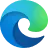
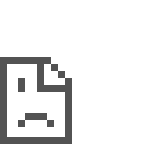
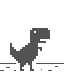
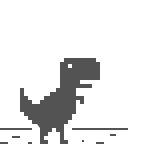
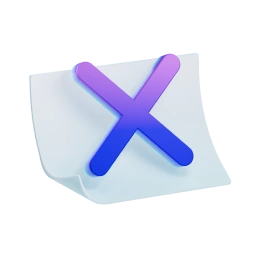
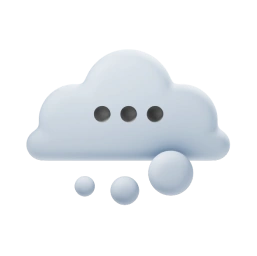
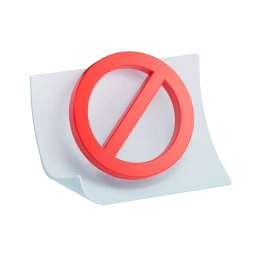
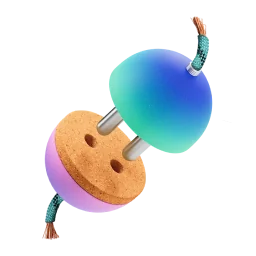
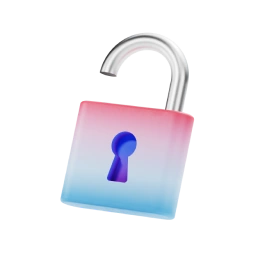
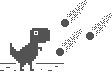
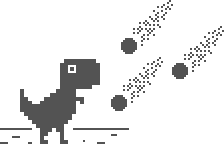
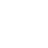
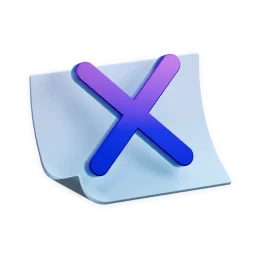
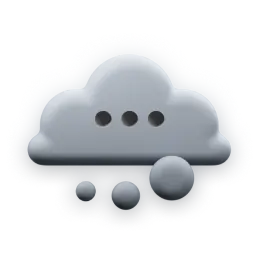
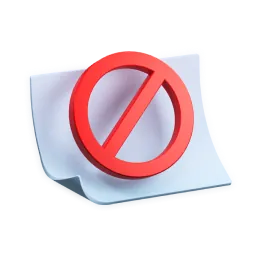
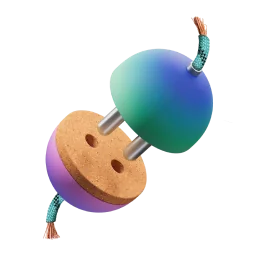
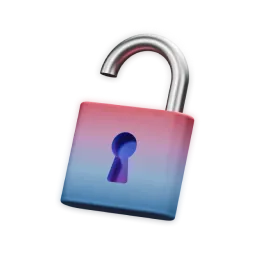
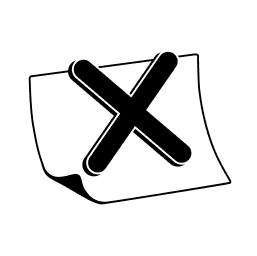
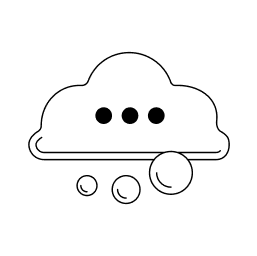
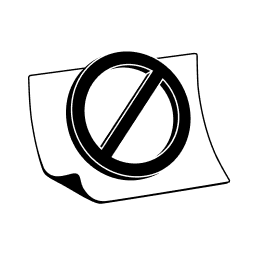
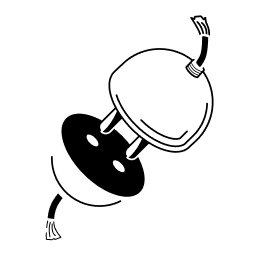
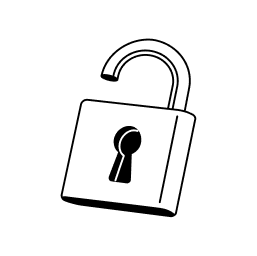
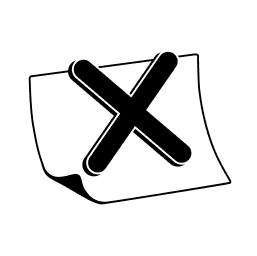
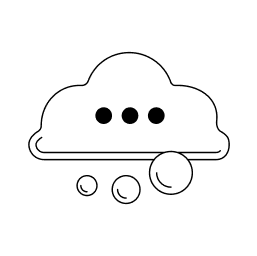
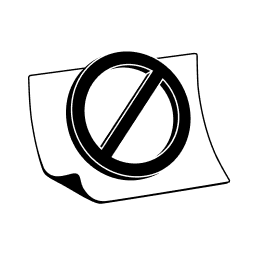
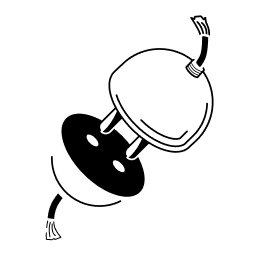
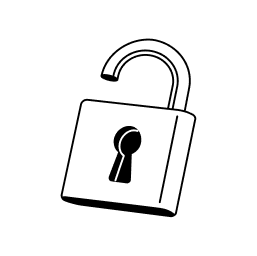
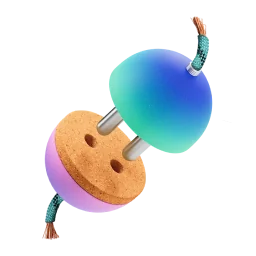
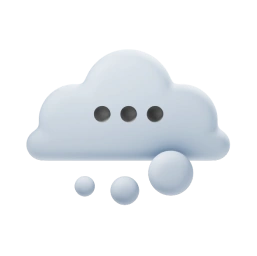
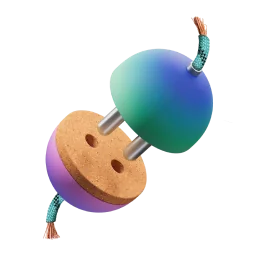
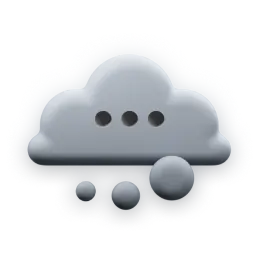
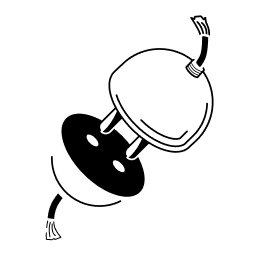
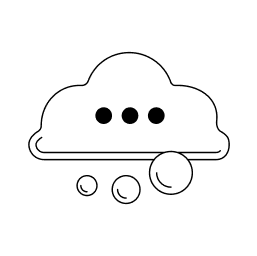

In [9]:

# create directory 'res_restaurant_scraping'
createDirectory(fh.STORE_RESTAURANT_SCRAPING, 'res_restaurant_scraping')

# *** select one province from 'ALL_REGION_ID_WONGNAI'
# *** so, change "Idx_of_region" everytime when scrape another province
Idx_of_region = 0
cur_region_data = ALL_REGION_ID_WONGNAI[Idx_of_region]

cur_province_en = cur_region_data[0]
cur_province_th = cur_region_data[1]
cur_regionId = cur_region_data[2]

# get dataframe result of all restaurants in current province
cur_res_allRestaurants_df = scrape_restaurants_by_province(
    wongnai_regionId = cur_regionId,
    province = cur_province_th,
)
# remove duplicate restaurant 
cur_res_allRestaurants_df.drop_duplicates(subset=['name', 'sub_name'], inplace=True)
# set new index
cur_res_allRestaurants_df.set_index(['name', 'sub_name'], inplace=True)

# save result dataframe to .csv
res_file_name = 'res_restaurant_%s.csv' % (cur_province_en)
res_path = os.path.join(fh.STORE_RESTAURANT_SCRAPING, 'res_restaurant_scraping', res_file_name) 
cur_res_allRestaurants_df.to_csv(res_path, encoding="utf-8")
    